In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


import os
# mnist_path = /PATH/TO/MNIST/DATA/
cfDir = os.path.expanduser("~/Desktop/Counterfactuals")
mnist_path = os.path.join(cfDir, "data", "MNIST")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # 1x28x28 -> 16x14x14
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), # 16x14x14 -> 32x7x7
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # 32x7x7 -> 64x4x4
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),                                           # 64x4x4 -> 1024
            nn.Linear(1024, 64),                                    # Latent space: 64
        )
        
        # Decoder (to match the 28x28 output size)
        self.decoder = nn.Sequential(
            nn.Linear(64, 1024),                                   # Latent space -> 1024
            nn.Unflatten(1, (64, 4, 4)),                           # 1024 -> 64x4x4
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # 64x4x4 -> 32x8x8
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # 32x8x8 -> 16x16x16
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(16, 1, kernel_size=2, stride=2, padding=2, output_padding=0),   # 16x16x16 -> 1x28x28
            nn.Sigmoid()  # Output between 0 and 1
        )

    def forward(self, x):
        # Ensure the input is reshaped to include a channel dimension (1, 28, 28) -> (1, 1, 28, 28)
        if x.dim() == 3:
            x = x.unsqueeze(1)  # Add channel dimension to make it (batch_size, 1, 28, 28)
        
        x = self.encoder(x)
        x = self.decoder(x)
        
        return x

In [3]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # Encoder components
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # 1x28x28 -> 16x14x14
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # 16x14x14 -> 32x7x7
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 32x7x7 -> 64x4x4
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten()  # 64x4x4 -> 1024
        )
        self.fc_mu = nn.Linear(1024, 64)
        self.fc_logvar = nn.Linear(1024, 64)
        
        # Decoder components
        self.decoder_input = nn.Linear(64, 1024)
        self.decoder_net = nn.Sequential(
            nn.Unflatten(1, (64, 4, 4)),                           # 1024 -> 64x4x4
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # 64x4x4 -> 32x8x8
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # 32x8x8 -> 16x16x16
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(16, 1, kernel_size=2, stride=2, padding=2, output_padding=0),   # 16x16x16 -> 1x28x28
            nn.Sigmoid()
        )
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def encoder(self, x):
        if x.dim() == 3:
            x = x.unsqueeze(1)
        x_enc = self.encoder_conv(x)
        mu = self.fc_mu(x_enc)
        logvar = self.fc_logvar(x_enc)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def decoder(self, z):
        x_recon = self.decoder_net(self.decoder_input(z))
        return x_recon

    def forward(self, x):
        z, mu, logvar = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon#, mu, logvar

In [4]:
# Function to display images and their reconstructions
def show_images(original, reconstructions, num_images=6, title="Reconstructions"):
    original = original.detach().cpu().numpy()
    reconstructions = reconstructions.detach().cpu().numpy()

    fig, axs = plt.subplots(2, num_images, figsize=(12, 4))
    
    for i in range(num_images):
        # Display original images
        axs[0, i].imshow(original[i][0], cmap='gray')
        axs[0, i].axis('off')
        # Display reconstructed images
        axs[1, i].imshow(reconstructions[i][0], cmap='gray')
        axs[1, i].axis('off')

    fig.suptitle(title)
    plt.show()

In [5]:
from torchvision import datasets, transforms
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

# Set download=True to download the dataset the first time
dataset1 = datasets.MNIST(mnist_path, train=True, download=False,
                    transform=transform)
dataset2 = datasets.MNIST(mnist_path, train=False, download=False, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=64, shuffle=False)# Ignoring cuda kwargs


## Train network

In [6]:
import torch.nn.functional as F
def sobel_loss(output):
    sobel_x = torch.tensor([[[[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]]], dtype=output.dtype, device=output.device)
    sobel_y = torch.tensor([[[[-1, -2, -1], [0, 0, 0], [1, 2, 1]]]], dtype=output.dtype, device=output.device)

    edges_x = F.conv2d(output, sobel_x, padding=1)
    edges_y = F.conv2d(output, sobel_y, padding=1)
    # edges = torch.sqrt(edges_x ** 2 + edges_y ** 2)
    edge_magnitude = torch.sqrt(torch.clamp(edges_x ** 2 + edges_y ** 2, min=1e-8))
    return edge_magnitude.mean()

In [8]:
torch.manual_seed(0)
import os
# autoencoder = Autoencoder().to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
autoencoder = VAE().to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
num_epochs = 3

vae_path = os.path.join(cfDir, "counterfactual-attacks", "MNIST", "Data", "mnist_autoencoder_weights.pth" )
if os.path.exists(vae_path):
    autoencoder.load_state_dict(torch.load(vae_path))
else:
    # Initialize autoencoder, loss, and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

    # Training loop
    # edge_weight = 0.4 # 0.5
    # l1_weight = 0.5
    edge_weight = 0.2
    l1_weight = 4 # .6, 2

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    for epoch in range(num_epochs):
        autoencoder.train()
        running_loss = 0.0
        
        # Training
        for i, (images, _) in enumerate(train_loader):
            # if i==500:
            #     break
            images = images.to(device)
            
            # Forward pass
            outputs = autoencoder(images)
            # loss = criterion(outputs, images)

            recon_loss = criterion(outputs, images)
            
            # L1 loss (sparse reconstruction)
            l1_loss = torch.mean(torch.abs(outputs - images))
            edge_penalty = sobel_loss(outputs)
            loss = criterion(outputs, images) + edge_weight * edge_penalty + l1_weight * l1_loss
            # tv_loss = total_variation_loss(outputs)
            # loss = recon_loss - 0.01 * tv_loss  # Adjust the TV loss weight as needed
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        train_loss = running_loss / len(train_loader)
        
        # Evaluate on test set
        autoencoder.eval()
        test_loss = 0.0
        with torch.no_grad():
            for images, _ in test_loader:
                images = images.to(device)
                outputs = autoencoder(images)
                
                l1_loss = torch.mean(torch.abs(outputs - images))
                edge_penalty = sobel_loss(outputs)
                loss = criterion(outputs, images) + edge_weight * edge_penalty + l1_weight * l1_loss
                # loss = criterion(outputs, images)
                test_loss += loss.item()
        
        test_loss /= len(test_loader)
        
        # Display training and test loss
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
        
        # Display a few examples of training and test reconstructions
        with torch.no_grad():
            
            # Show reconstructions for the first batch of test images
            test_images, _ = next(iter(test_loader))
            test_images = test_images.to(device)
            test_reconstructions = autoencoder(test_images)
            show_images(test_images, test_reconstructions, title=f"Epoch {epoch+1} - Test Set")

    print("Training Complete.")
    
    print(criterion(outputs, images), edge_weight * edge_penalty,  l1_weight * l1_loss)

    # Save model weights
    torch.save(autoencoder.state_dict(), vae_path)

/var/folders/6s/0_393zzn0yq8nrvdrklw8k1w0000gn/T/ipykernel_67854/3557504800.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load(vae_pa

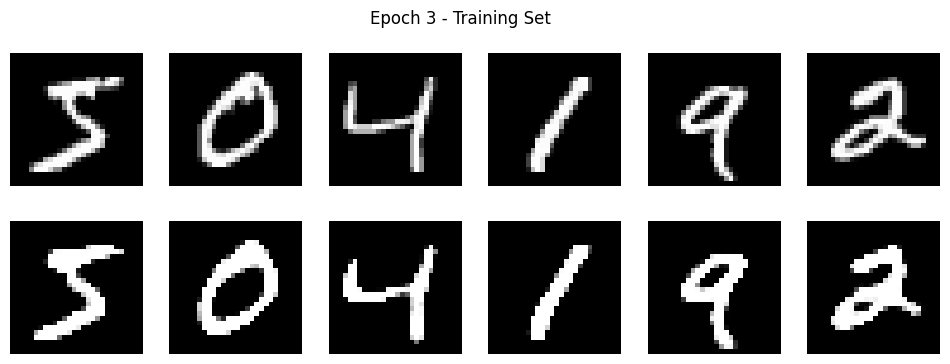

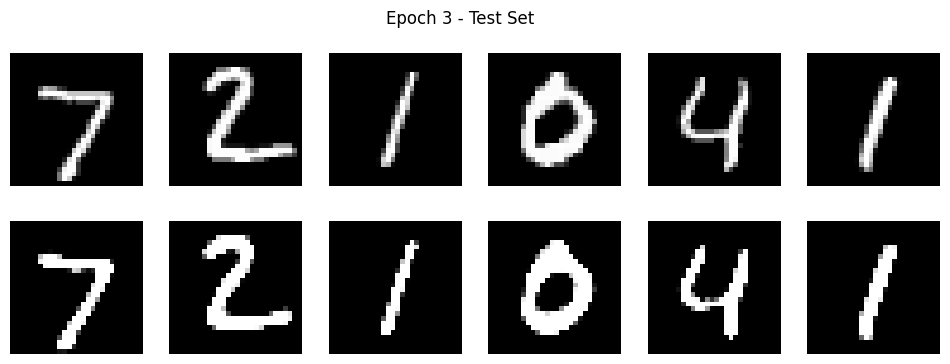

In [9]:
with torch.no_grad():        
    train_images, _ = next(iter(train_loader))
    train_images = train_images.to(device)
    train_reconstructions = autoencoder(train_images)
    show_images(train_images, train_reconstructions, title=f"Epoch {num_epochs} - Training Set")

    # Show reconstructions for the first batch of test images
    test_images, _ = next(iter(test_loader))
    test_images = test_images.to(device)
    test_reconstructions = autoencoder(test_images)
    show_images(test_images, test_reconstructions, title=f"Epoch {num_epochs} - Test Set")

    

## Train a classifier (or load)

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


# Simple classifier for MNIST
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # 1x28x28 -> 32x28x28
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                                    # 32x28x28 -> 32x14x14

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # 32x14x14 -> 64x14x14
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                                    # 64x14x14 -> 64x7x7

            nn.Flatten(),                                          # 64x7x7 -> 3136
            nn.Linear(64 * 7 * 7, 128),                            # Fully connected layer
            nn.ReLU(),
            nn.Linear(128, 10)                                     # Output layer (10 classes)
        )
    
    def forward(self, x):
        return self.network(x)

In [ ]:
# Initialize the classifier
classifier = Classifier().to(device)
criterion_cls = nn.CrossEntropyLoss()

pred_path = os.path.join(cfDir, "counterfactual-attacks", "MNIST", "Data", "mnist_classifier_weights.pth" )
if os.path.exists(pred_path):
    classifier.load_state_dict(torch.load(pred_path))
else:

    # Loss function and optimizer
    
    optimizer = optim.Adam(classifier.parameters(), lr=0.001)

    # Training loop
    num_epochs = 1
    torch.manual_seed(0)
    for epoch in range(num_epochs):
        classifier.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = classifier(images)
            loss = criterion_cls(outputs, labels)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            # Accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Running Train Accuracy: {train_accuracy:.2f}%")
    torch.save(classifier.state_dict(), pred_path)

/var/folders/6s/0_393zzn0yq8nrvdrklw8k1w0000gn/T/ipykernel_67854/293693375.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  classifier.load_state_dict(torch.load(pred_pat

### Evaluate performance

In [13]:
classifier.eval()
def eval_classifier(data_loader):
    correct = 0
    # total = 0
    all_loss = 0.0

    # Initialize lists to store all predictions and true labels
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = classifier(images)
            loss = criterion_cls(outputs, labels)
            all_loss += loss.item()
            
            # Get predictions
            _, predicted = torch.max(outputs.data, 1)
            
            # Append predictions and true labels to lists
            all_preds.append(predicted.cpu())   # Move predictions to CPU before appending
            all_labels.append(labels.cpu())     # Move labels to CPU before appending
            
            # total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Concatenate the list of tensors into single tensors for easier analysis
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    return all_preds, all_labels, all_loss, correct

all_preds_test, all_labels_test, test_loss, correct = eval_classifier(test_loader)
test_loss = test_loss / len(test_loader)
total = len(test_loader.dataset)
test_accuracy = 100 * correct / total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

all_preds_train, all_labels_train, train_loss, correct = eval_classifier(train_loader)
train_loss = train_loss / len(train_loader)
total = len(train_loader.dataset)
train_accuracy = 100 * correct / total
print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

Test Loss: 0.0652, Test Accuracy: 97.86%
Train Loss: 0.0683, Train Accuracy: 97.76%


### Function for counterfactual

In [14]:
def generate_counterfactual(generator, latent_vector, classifier, Class, threshold, 
                    max_n_iter=1000, verbose=False, 
                    learning_rate=0.1, store_intermediate=False):
    latent = latent_vector.clone().detach().requires_grad_(True)
    intermediate_ims = []
    softmax = nn.Softmax(dim=1)
    optimizer = torch.optim.Adam([latent], lr=learning_rate)
    for i in range(max_n_iter):
        # Generate synthetic image
        image_recon = generator(latent)
        if store_intermediate and i%50==0:
            intermediate_ims.append(image_recon.cpu().detach())
        
        # Get prediction on class of interest
        predictions = softmax(classifier(image_recon))
        predicted_prob = predictions[0,Class]

        # Reached desired counterfactual score
        if predicted_prob > threshold:
            break

        # Backpropagate
        optimizer.zero_grad()
        (-predicted_prob).backward(retain_graph=True)
        optimizer.step()
        if verbose and (i+1) % 50 == 0:
            print(f"Iteration {i+1}/{max_n_iter}, Prediction: {predicted_prob.item():.3f}")
    
    if i==max_n_iter-1:
        if verbose:
            print("Failed to converge.")
        converged = False
    else:
        converged = True
    if store_intermediate:
        return latent, converged, intermediate_ims
    return latent, converged

## Look at predictor's failure modes

In [15]:
# Extract the corresponding image from the data loader
def get_image_from_loader(loader, index):
    # Find the batch and the index within that batch
    current_idx = 0
    for images, labels in loader:
        batch_size = images.size(0)
        if current_idx + batch_size > index:
            # This batch contains the desired image
            image = images[index - current_idx]
            label = labels[index - current_idx]
            return image, label
        current_idx += batch_size


Predictions on original image:		tensor([[82.,  0.,  0.,  0.,  0.,  2., 15.,  0.,  0.,  0.]])
Predictions on autoencoder output:	tensor([[52.,  0.,  1.,  0.,  0., 15., 27.,  1.,  2.,  1.]])


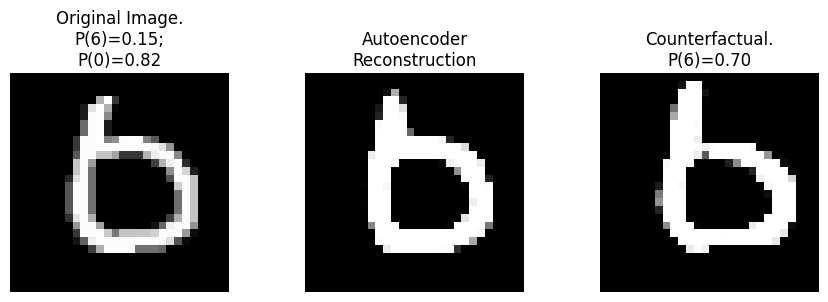

In [22]:
# Find the first index where prediction != label
error_idx = 13 # 10, 13 good
mismatch_indices = (all_preds_train != all_labels_train).nonzero(as_tuple=False)
mismatch_idx = mismatch_indices[error_idx].item()

# Get the original image and the true label at mismatch_idx
# mismatch_image, mismatch_label = get_image_from_loader(test_loader, mismatch_idx)
mismatch_image, mismatch_label = get_image_from_loader(train_loader, mismatch_idx)

# Model prediction for the mismatched image
mismatch_pred = all_preds_train[mismatch_idx].item()

mismatch_image = mismatch_image.cpu()
logits_og  = classifier(mismatch_image.unsqueeze(0))
logits_auto  = classifier(autoencoder(mismatch_image))
with torch.no_grad():
    softmax = nn.Softmax(dim=1)
    probs_og = softmax(logits_og)
    probs_auto = softmax(logits_auto)
print("Predictions on original image:\t\t{}".format(torch.round(probs_og*100).detach()))
print("Predictions on autoencoder output:\t{}".format(torch.round(probs_auto*100).detach()))

# Do need to be cautious: Reconstructed image's probability for desired class may alreday be that high.
# threshold = probs_og.max().item()
threshold = 0.75
# latent = autoencoder.encoder(mismatch_image.unsqueeze(0))
latent = autoencoder.encoder(mismatch_image.unsqueeze(0))[0]
true_class = mismatch_label.item()

latent_counterfactual, _ = generate_counterfactual(autoencoder.decoder, latent, classifier, true_class, threshold, learning_rate=.01)
counterfactual = autoencoder.decoder(latent_counterfactual)

og_pred = softmax(classifier(mismatch_image.unsqueeze(0)))[0,true_class].item()
cf_pred = softmax(classifier(counterfactual))[0,true_class].item()

fig, ax = plt.subplots(1, 3, figsize=(9, 3))

ax[0].imshow(mismatch_image.squeeze(), cmap='gray')
ax[0].set_title(f"Original Image.\nP({true_class})={og_pred:.2f};\nP({torch.argmax(probs_og)})={probs_og.max():.2f}")
ax[0].axis('off')

ax[1].imshow(autoencoder(mismatch_image).detach().squeeze(), cmap='gray')
ax[1].set_title("Autoencoder\nReconstruction")
ax[1].axis('off')

ax[2].imshow(counterfactual.detach().squeeze(), cmap='gray')
ax[2].set_title(f"Counterfactual.\nP({true_class})={cf_pred:.2f}")
ax[2].axis('off')

plt.tight_layout()
plt.show()

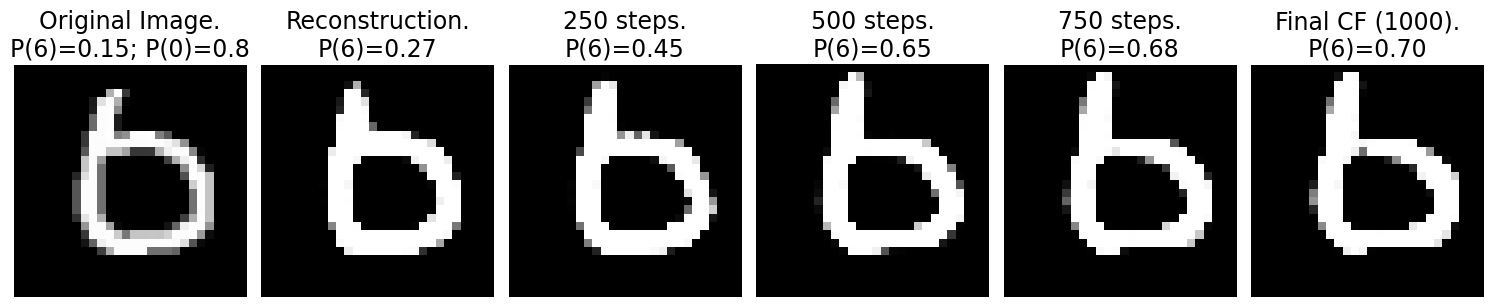

In [26]:
# Choose 5 evenly spaced indices
latent_counterfactual, _, intermediate_ims = generate_counterfactual(autoencoder.decoder, latent, classifier, 
                                                                     true_class, threshold, learning_rate=.01,
                                                                     store_intermediate=True)

n_images = len(intermediate_ims)
indices = [int(i * (n_images - 1) / 4) for i in range(5)]

fig, axs = plt.subplots(1, 6, figsize=(15, 4))

# Original image on first axis
axs[0].imshow(mismatch_image.squeeze(), cmap='gray')
# axs[0].set_title(f"Original Image.\nP({true_class})={og_pred:.2f};\nP({torch.argmax(probs_og)})={probs_og.max():.2f}")
axs[0].set_title(f"Original Image.\nP({true_class})={probs_og[0,true_class]:.2f}; P({torch.argmax(probs_og)})={probs_og.max():.1f}", fontsize=17)
axs[0].axis('off')

# Progression images on remaining axes
for i, (ax, idx) in enumerate(zip(axs[1:], indices)):
    prob = softmax(classifier(intermediate_ims[idx]))[0, true_class].item()
    ax.imshow(intermediate_ims[idx].squeeze(), cmap='gray')
    if i==0:
        ax.set_title(f'Reconstruction.\nP({true_class})={prob:.2f}', fontsize=17)
    elif i==4:
        ax.set_title(f'Final CF ({(indices[i]+1)*50}).\nP({true_class})={prob:.2f}', fontsize=17)
    else:
        ax.set_title(f'{(indices[i]+1)*50} steps.\nP({true_class})={prob:.2f}', fontsize=17)
    ax.axis('off')

# plt.suptitle("Counterfactual Progression", fontsize=20)
plt.tight_layout()
figDir = os.path.join(cfDir, "counterfactual-attacks", "MNIST", "Figures")
prog_path = os.path.join(figDir, "mnist_progression.pdf")
plt.savefig(prog_path, bbox_inches="tight", format='pdf', dpi=300)
plt.show()

## Convert a bunch of failures

9 tensor(0.4445)
7 tensor(0.2808)
7 tensor(0.4317)
3 tensor(0.3162)
0 tensor(0.3800)
0 tensor(0.4193)
8 tensor(0.4609)
8 tensor(0.3349)


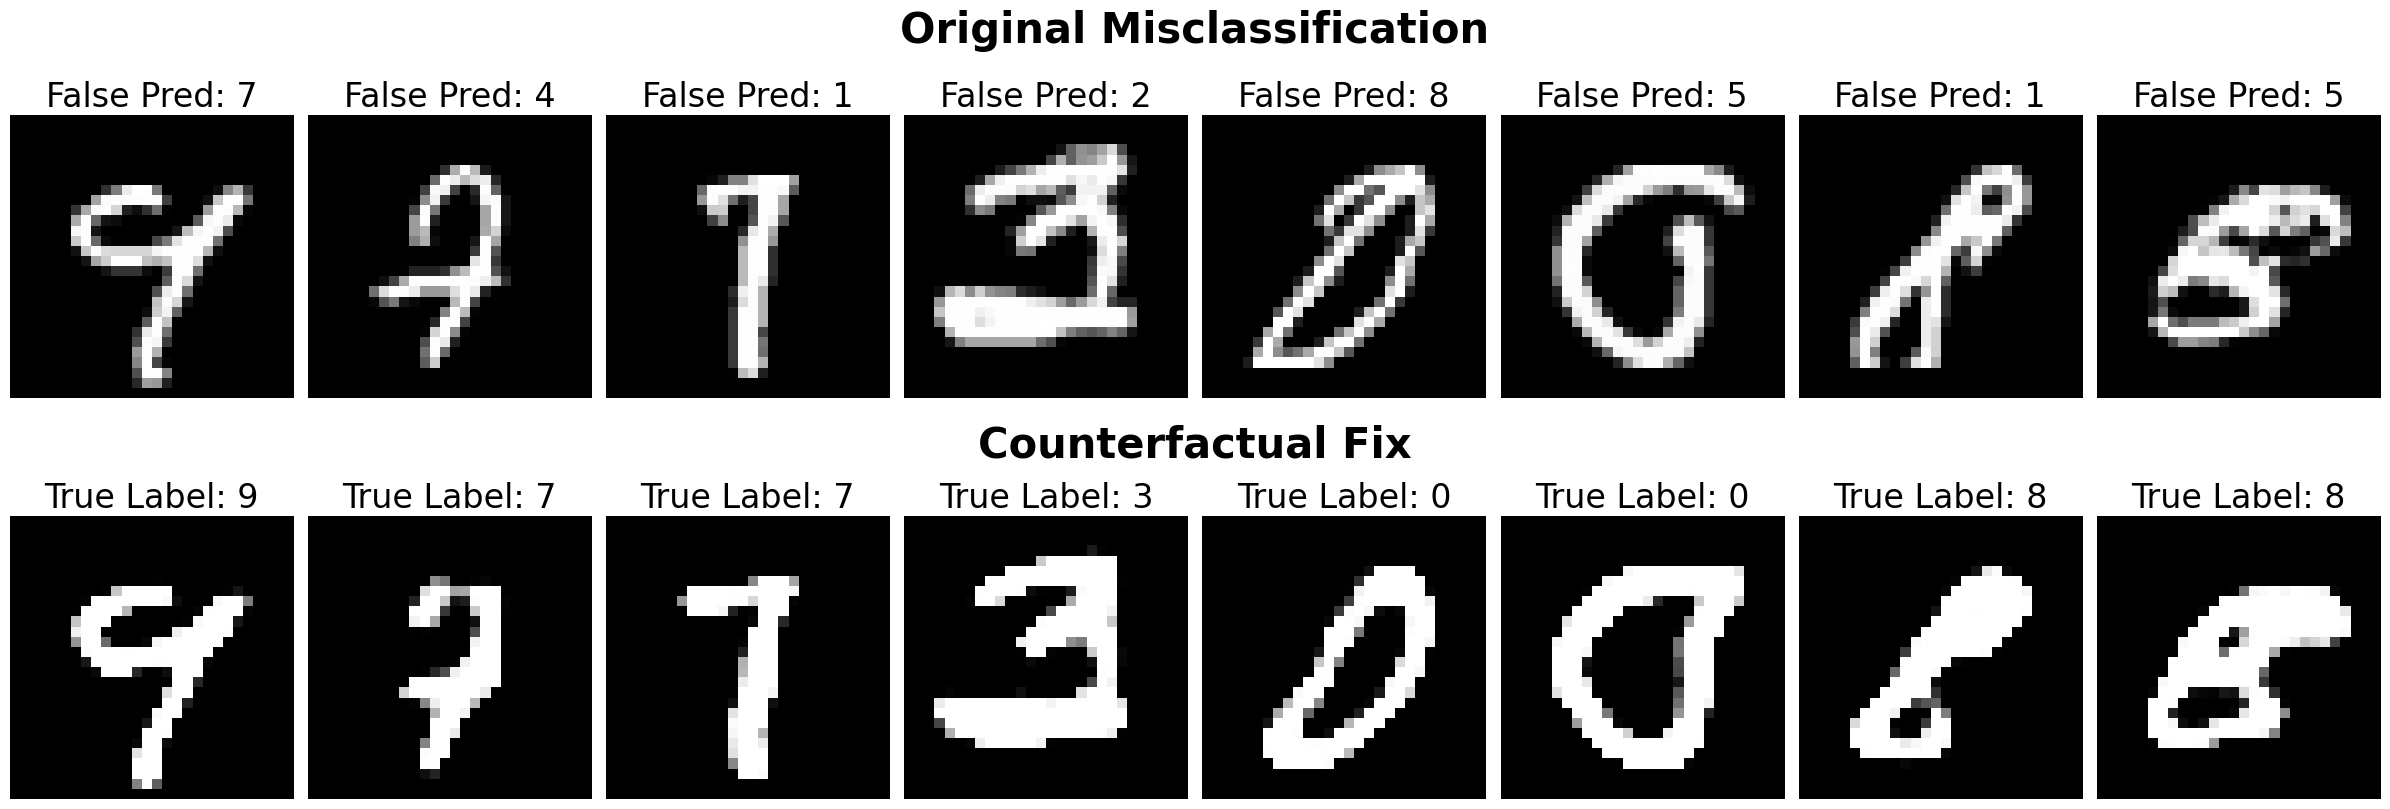

In [ ]:
n_errors = min(8, len(mismatch_indices))
fig, ax = plt.subplots(2, n_errors, figsize=(3 * n_errors, 9))
softmax = nn.Softmax(dim=1)
n_successes = 0
# for i in range(n_errors):
i = 0
while n_successes < n_errors:
    idx = mismatch_indices[i].item()
    i += 1
    # Retrieve image and true label from loader
    mismatch_image, mismatch_label = get_image_from_loader(train_loader, idx)
    mismatch_image = mismatch_image.cpu()
    true_label = mismatch_label.item()
    with torch.no_grad():
        recon = autoencoder(mismatch_image.unsqueeze(0))
        pred = softmax(classifier(recon))
        if pred[0,true_label] != pred.max():
            continue
        else:
            print(true_label, pred[0,true_label])
    
    # Generate latent representation and counterfactual latent
    latent, _, _ = autoencoder.encoder(mismatch_image.unsqueeze(0))
    latent_counterfactual, converged = generate_counterfactual(autoencoder.decoder, latent, classifier, true_label, threshold, verbose=False, learning_rate=.1)
    if converged:
        counterfactual = autoencoder.decoder(latent_counterfactual)
        
        # Get classifier predicted label for original image
        with torch.no_grad():
            pred_label = classifier(mismatch_image.unsqueeze(0)).argmax(dim=1).item()
        
        # Plot original image (top row) with larger font for labels
        ax[0, n_successes].imshow(mismatch_image.squeeze(), cmap='gray')
        # ax[0, i].set_title(f"True: {true_label}\nFalse: {pred_label}", fontsize=16)
        ax[0, n_successes].set_title(f"False Pred: {pred_label}", fontsize=25)
        ax[0, n_successes].axis('off')
        
        # Plot counterfactual image (bottom row) without inner titles
        ax[1, n_successes].imshow(counterfactual.detach().squeeze(), cmap='gray')
        ax[1, n_successes].set_title(f"True Label: {true_label}", fontsize=25)
        ax[1, n_successes].axis('off')

        n_successes += 1
    else:
        continue
    

# Add row titles using fig.text
fig.text(0.5, 0.96, "Original Misclassification", ha="center", fontsize=30, weight="bold")
fig.text(0.5, 0.5, "Counterfactual Fix", ha="center", fontsize=30, weight="bold")

# plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.tight_layout()
fail_path = os.path.join(figDir, "mnist_failure_analyses.pdf")
plt.savefig(fail_path, bbox_inches="tight", format='pdf', dpi=300)
plt.show()

## Convert one number into another

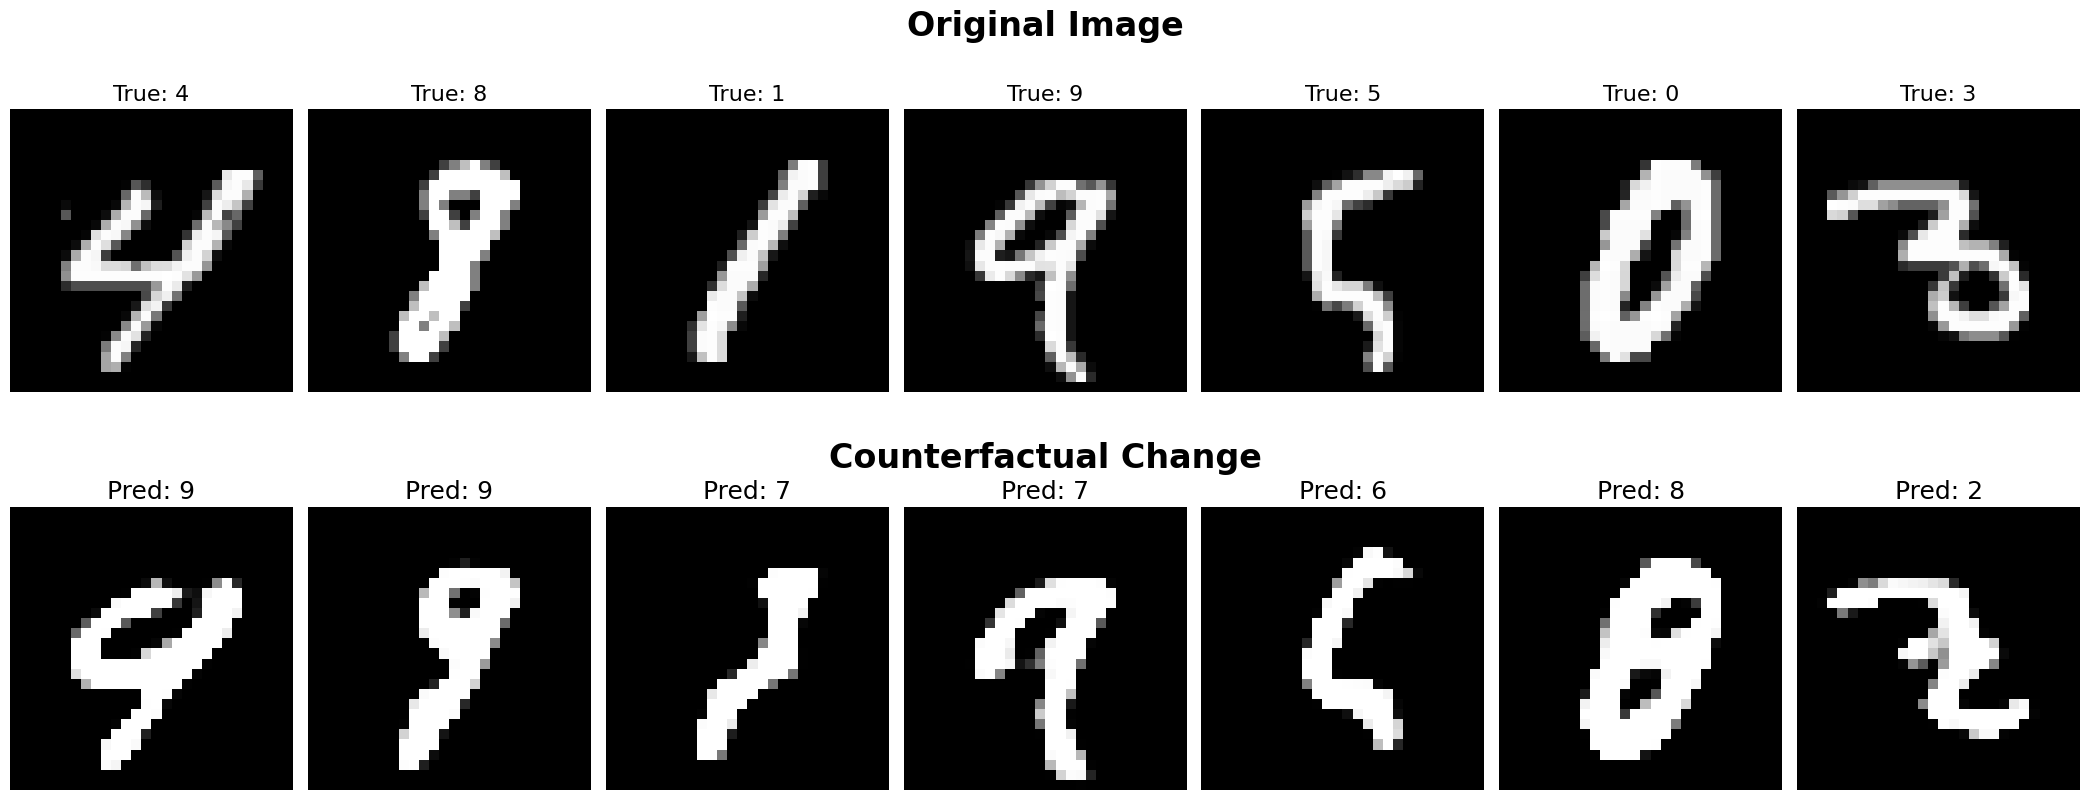

In [ ]:
# Define the desired (true_label, counterfactual_label, feat_idx) tuples:
pairs = [(4, 9, 9), (8, 9, 9), (1, 7, 0), (9, 7, 0), (5, 6, 5), (0, 8, 2), (3, 2, 4)]

n_cols = len(pairs)
fig, ax = plt.subplots(2, n_cols, figsize=(3 * n_cols, 9))
threshold = 0.5  # threshold for counterfactual generation

for i, (true_label, cf_label, feat_idx) in enumerate(pairs):
    # Select an image index where the true label is as specified
    indices = (all_labels_train == true_label).nonzero(as_tuple=False)
    im_idx = indices[feat_idx].item()
    
    # Retrieve the original image (and ignore its label since we know it)
    image, _ = get_image_from_loader(train_loader, im_idx)
    image = image.cpu()
    
    # Generate counterfactual:
    feat_image_input = image.unsqueeze(0)
    latent = autoencoder.encoder(feat_image_input)[0]
    latent_counterfactual, converged = generate_counterfactual(autoencoder.decoder, latent, classifier, cf_label, 
                                                               threshold, max_n_iter=5000, verbose=False, learning_rate=.1)
    counterfactual = autoencoder.decoder(latent_counterfactual)
    
    # Top row: Original image with true and predicted labels (large font)
    ax[0, i].imshow(image.permute(1, 2, 0).squeeze(), cmap='gray')
    ax[0, i].set_title(f"True: {true_label}", fontsize=16)#\nPred: {cf_label}
    ax[0, i].axis('off')
    
    # Bottom row: Counterfactual image (no title)
    ax[1, i].imshow(counterfactual.detach().cpu()[0].permute(1, 2, 0).squeeze(), cmap='gray')
    ax[1, i].set_title(f"Pred: {cf_label}", fontsize=18)
    ax[1, i].axis('off')

# Add overarching row titles for the grid
fig.text(0.5, 0.96, "Original Image", ha="center", fontsize=24, weight="bold")
fig.text(0.5, 0.48, "Counterfactual Change", ha="center", fontsize=24, weight="bold")

plt.tight_layout()#rect=[0, 0, 1, 0.93]
edit_path = os.path.join(figDir, "mnist_edits.pdf")
plt.savefig(edit_path, bbox_inches="tight", format='pdf', dpi=300)
plt.show()